# End-to-end Multi_Class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem
Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know the breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification completion.

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with probabilities for each dog breed of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation


## 4. Features

Some information about the data:
* We're dealing with timages (unstructured data) so it's probably best we use deep learning/transfer learning.

* There are 120 breeds of dogs ( this means there are 120 different classes).

* There are around 10,000+ images in the training set
(these images have labels)

* There are around 10,000+ images in the test set
(these images have no labels, because we'll want to predict them).


In [ ]:
# Use the '-d' parameter as the destination for where the files should go
#!unzip "drive/My Drive/Data/dog-breed-identification.zip" -d "drive/My Drive/Data/"

Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

In [ ]:
pip install tensorflow==2.12.0 tensorflow-hub==0.13.0


INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 8.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  

In [ ]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print ("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSS!!!!)" if tf.config.list_physical_devices("GPU")else "not available :(")




TF version: 2.12.0
TF Hub version: 0.13.0
GPU not available :(


## Getting our data ready (turning into Tensors)

 With all machine learning models, our data has to be in numerical format. So that's what we will be doing first. Turning our images into Tensors (numerical representations).

 Let's start by accessing our data and checking out the labels.

In [ ]:

# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())


                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


<Axes: xlabel='breed'>

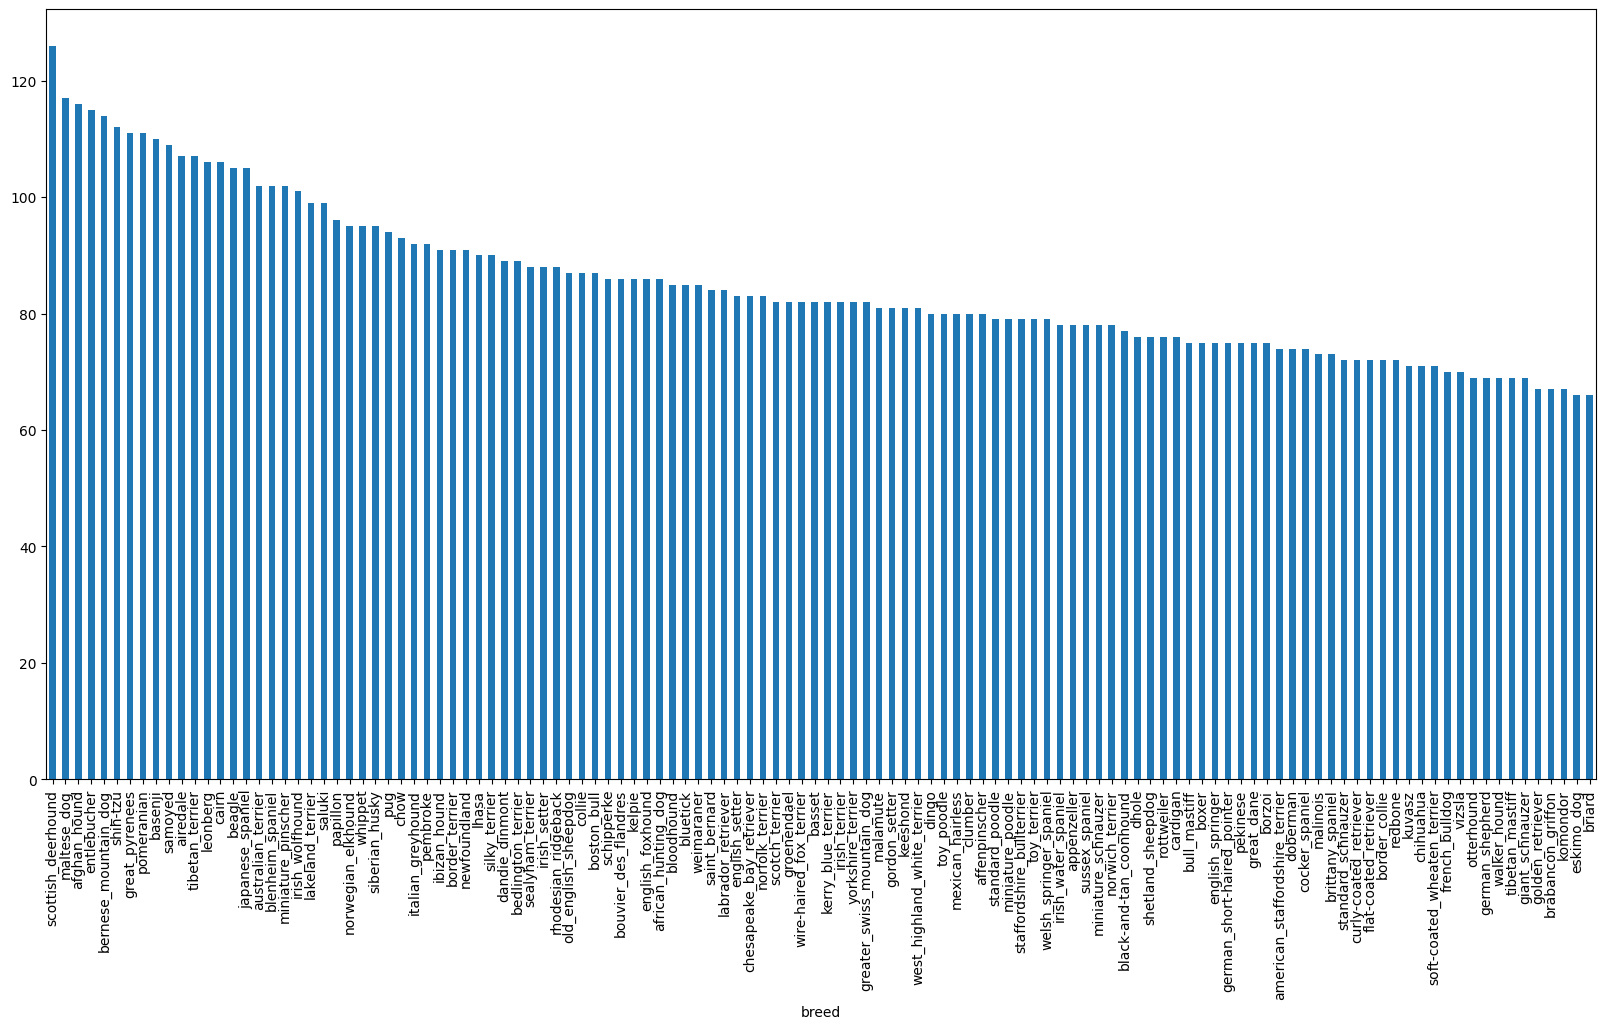

In [ ]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

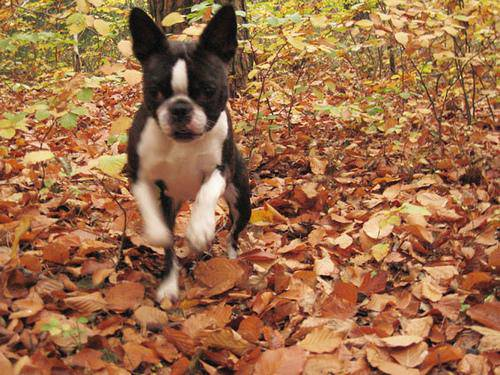

In [ ]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

In [ ]:

# Create pathnames from image ID's
filenames = ["drive/My Drive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10 filenames
filenames[:10]
len(filenames)

10222

In [ ]:
import os
import shutil

# Path to your train directory
train_dir = "drive/My Drive/Dog Vision/train/"

# Get all files in the directory
all_files = os.listdir(train_dir)

# Identify files to remove (hidden or non-jpg)
files_to_remove = [
    f for f in all_files
    if (f.startswith(".") or not f.endswith(".jpg"))
]

# Remove the identified files
for file_name in files_to_remove:
    file_path = os.path.join(train_dir, file_name)
    if os.path.isfile(file_path):
        os.remove(file_path)
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)  # Use shutil.rmtree for directories

print(f"Removed {len(files_to_remove)} extra files from {train_dir}")

Removed 0 extra files from drive/My Drive/Dog Vision/train/


In [ ]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!


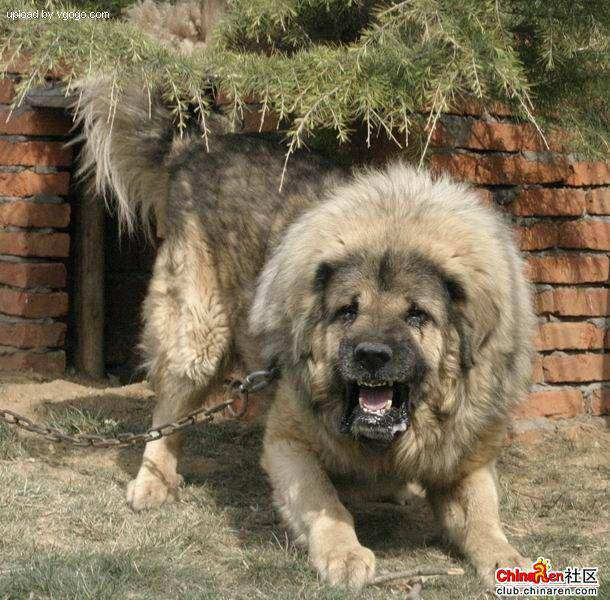

In [ ]:
#One more check
Image(filenames[9000])

In [ ]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've got our training image filepaths in a list, let's prepare our labels.

In [ ]:
import numpy as np
labels = labels_csv ["breed"].to_numpy()

#labels = np.array(labels)
labels


array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
    print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]


[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs)
print(boolean_labels[0].argmax()) # index where label occours in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

### Creating our own validation set
Since the dataset from Kaggle doesn't come with validation set, we're going to create our own.

In [ ]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [ ]:
len(filenames)

10222

We're going to start off experimenting with ~1000 images and increase as needed.

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

#Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state=42)

In [ ]:
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Let's have a geez at the training data
X_train[:5], y_train[:5]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

Preprocessing images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be shape of (224, 224)
5. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [ ]:
# Convert image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
#Turn image into tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1
5. Resize the `image` to be shape of (224, 224)
6. Return the modified `image`

In [ ]:

# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [ ]:
tensor = tf.io.read_file(filenames[26])
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01\xf4\x01w\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca


## Turning our data into batches

Why turn our data into baches?
Let's say you're trying to process 10,000+ images in one
go....they all might not fit into memory.
So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).


In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`.

In [ ]:

# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [ ]:
#Demo of the above
(process_image(X[42]), tf.constant(y[42]))

In [ ]:



tensor = tf.image.decode_jpeg(tensor, channels=3)
tf.image.convert_image_dtype(tensor, tf.float32)

<tf.Tensor: shape=(500, 375, 3), dtype=float32, numpy=
array([[[0.23137257, 0.26666668, 0.25490198],
        [0.2509804 , 0.28627452, 0.27450982],
        [0.2784314 , 0.3137255 , 0.3019608 ],
        ...,
        [0.45098042, 0.5019608 , 0.42352945],
        [0.45098042, 0.5019608 , 0.42352945],
        [0.43137258, 0.48235297, 0.4039216 ]],

       [[0.25490198, 0.2901961 , 0.2784314 ],
        [0.28235295, 0.31764707, 0.30588236],
        [0.30980393, 0.34509805, 0.33333334],
        ...,
        [0.44705886, 0.49803925, 0.41960788],
        [0.45882356, 0.50980395, 0.43137258],
        [0.454902  , 0.5058824 , 0.427451  ]],

       [[0.26666668, 0.3019608 , 0.2901961 ],
        [0.29803923, 0.33333334, 0.32156864],
        [0.3254902 , 0.36078432, 0.34901962],
        ...,
        [0.44705886, 0.49803925, 0.41960788],
        [0.47058827, 0.52156866, 0.4431373 ],
        [0.48235297, 0.53333336, 0.454902  ]],

       ...,

       [[0.6784314 , 0.7843138 , 0.60784316],
        [0.64

Now we've got a way to turn our data into tuples of Tensors
in the form: `(image, label)`, let's make a function to turn all of our data (X & y) into batches!

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label



In [ ]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch


In [ ]:

#Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualiing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them.

In [ ]:

import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")



In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

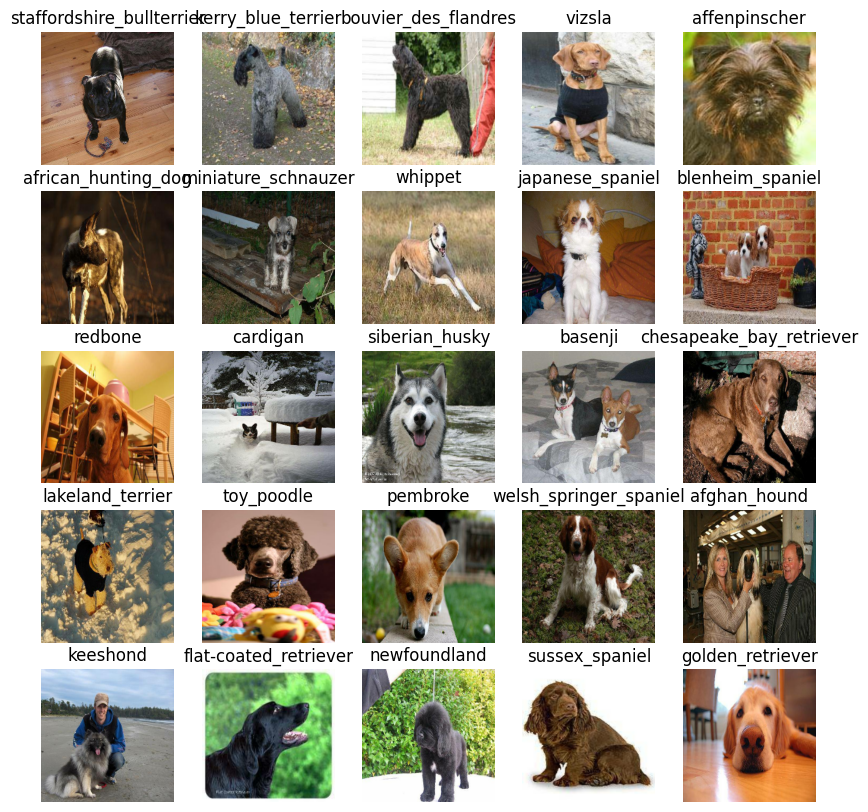

In [ ]:

# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [ ]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model
Before we build a model, there are a few things we need to define:
* The input shape ( our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use. https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification/1?tfhub-redirect=true


In [ ]:

# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [ ]:
IMG_SIZE

224

Now we've got oir inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these step can be found here: https://www.tensorflow.org/guide/keras/overview

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting

  return model


In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


###Creating callbacks

Calllbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stoping which prevents our model from training for too long.


### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model"s 'fit()' function.
3. Visualize our models training logs with the %tensorboard magic function (we"ll this after model training)

In [ ]:


# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

#Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%H%S"))
  return tf.keras.callbacks.TensorBoard(logdir)



### Early Stopping Callback
Early Stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops.
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

Training a model (on subset of data)
our first model is only going to train on 1000 images, to make sure everything is working.

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

Let's create a function which trains a model.
* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validatiaon data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model


In [ ]:

# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])

  return model

In [ ]:

# Fit the model to the data
import os
model = train_model()


Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 465s 19s/step - loss: 4.6032 - accuracy: 0.0950 - val_loss: 3.5129 - val_accuracy: 0.2350
Epoch 2/100
25/25 [==============================] - 83s 3s/step - loss: 1.6715 - accuracy: 0.6675 - val_loss: 2.2484 - val_accuracy: 0.4950
Epoch 3/100
25/25 [==============================] - 70s 3s/step - loss: 0.5927 - accuracy: 0.9362 - val_loss: 1.7283 - val_accuracy: 0.5700
Epoch 4/100
25/25 [==============================] - 77s 3s/step - loss: 0.2607 - accuracy: 0.9875 - val_loss: 1.5476 - val_accuracy: 0.5800
Epoch 5/100
25/25 [==============================] - 63s 3s/step - loss: 0.1540 - accuracy: 0.9937 - val_loss: 1.4752 - val_accuracy: 0.5950
Epoch 6/100
25/25 [==============================] - 70s 3s/step - loss: 0.1039 - accuracy: 0.9987 - val_loss: 1.4160 - val_accuracy: 0.6100
Epoch 7/100
25/25 [==============================] - 72s 3s

In [ ]:
### Checking the TensorBoard logs

#The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

%tensorboard --logdir drive/My\ Drive/Dog\ Vision/logs

<IPython.core.display.Javascript object>

## Making and evaluating predictions using a trained model

In [ ]:
# Make predictions on the validation data ( not used to train on)
predictions = model.predict(val_data,verbose=1)
predictions

7/7 [==============================] - 14s 2s/step


array([[9.0497290e-04, 1.7496815e-04, 7.1531307e-04, ..., 1.2969469e-03,
        6.3661770e-05, 7.0781060e-03],
       [3.0076311e-03, 6.2463229e-04, 1.5685869e-02, ..., 1.1584929e-03,
        4.9588969e-03, 8.8016270e-05],
       [4.2363019e-05, 1.2412030e-05, 1.6253132e-04, ..., 5.7697827e-05,
        3.7173271e-05, 8.7680115e-04],
       ...,
       [8.4559115e-06, 1.0065224e-04, 3.1952152e-06, ..., 1.0074535e-05,
        1.7109729e-05, 9.2468836e-05],
       [2.4249631e-03, 5.7357288e-04, 1.9590008e-04, ..., 7.3779991e-04,
        8.8077046e-05, 9.5782327e-03],
       [7.5024308e-04, 3.0697891e-05, 2.3046156e-04, ..., 4.2204475e-03,
        7.4836507e-04, 5.7914025e-05]], dtype=float32)

In [ ]:
# Check the shape of predictions
predictions.shape

NameError: name 'predictions' is not defined

In [ ]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label

[9.0497290e-04 1.7496815e-04 7.1531307e-04 1.0571294e-04 8.3480874e-04
 4.3465341e-05 2.3879291e-02 1.0674602e-03 3.9310489e-04 2.4157720e-04
 1.2254778e-04 1.1282538e-04 1.0243319e-03 3.7850921e-05 5.8472366e-04
 4.2446100e-04 4.6463039e-05 1.2960488e-01 9.4539537e-05 6.0867453e-05
 6.5002049e-04 2.4656445e-04 8.8686880e-05 6.8273135e-03 4.2120140e-05
 3.2175399e-04 1.4580952e-01 4.7535494e-05 7.2820508e-04 5.9259107e-04
 4.1948588e-04 1.0355992e-03 1.7489992e-03 2.3969025e-05 6.9980283e-04
 1.3658461e-02 1.5960830e-05 3.8495380e-04 2.5576310e-05 1.2241532e-04
 1.0828179e-03 1.2260232e-04 4.4949577e-04 2.7811131e-04 6.4759399e-05
 7.2207447e-05 7.4135445e-05 1.2937764e-04 1.8559995e-03 5.9243004e-05
 7.4879639e-04 4.3876524e-05 6.9249934e-04 1.4628035e-04 9.0887144e-05
 2.6941081e-04 8.1451057e-04 7.5787916e-03 1.3273713e-03 1.7205384e-01
 3.2290074e-04 2.1787289e-04 2.0336997e-02 1.1163184e-05 7.7547965e-04
 1.2136785e-02 3.7733931e-04 5.2727328e-04 5.6697335e-03 1.2017056e-04
 2.297

Having the above functionality is greate but we want to be able to do it at scale.
And it would be even better if we could see the image the prediction is being made on.

**Note:** Prediction probabilities are also known as confident levels.

In [ ]:

# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label


'silky_terrier'

Since our validation data is still in a batch dataset,
we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [ ]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:

# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

In [ ]:
get_pred_label (val_labels[0])

'affenpinscher'

In [ ]:
images_ = []
labels_ = []

# Loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(label)

# Display the first image and label
print(images_[0], labels_[0])

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visualize.
We'll create a function which
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer.  
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if np.any(pred_label == true_label):
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

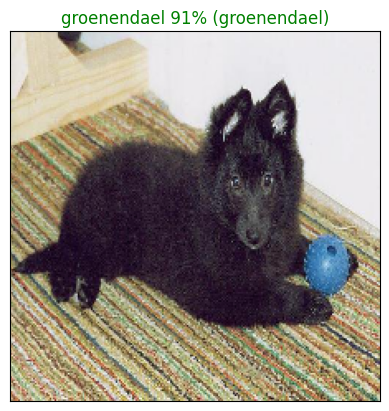

In [ ]:

# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer
* Find the prediction using get_pred_label()
* Find the top 10:
 * Prediction probabilities indexes
 * Prediction probabilities values
 * Prediction labels

 * Plot the top 10 prediction probability values and labels, coloring the true label green

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the prediction label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

# Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color = "grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation= "vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")

  else:
    pass


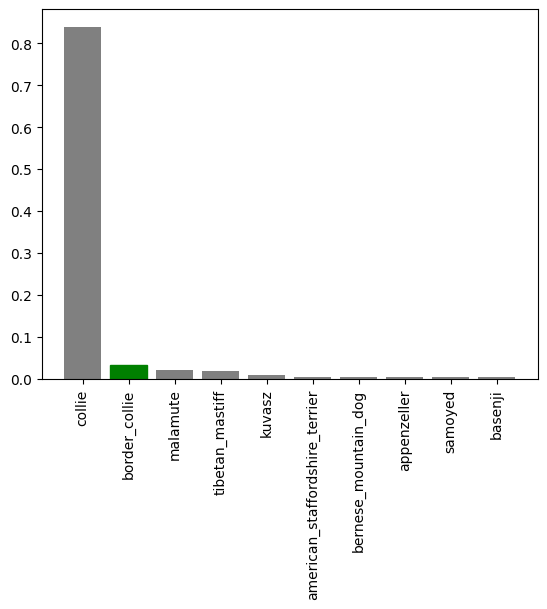

In [ ]:
plot_pred_conf(prediction_probabilities = predictions,
               labels=val_labels,
               n=9)

In [ ]:
predictions[0][predictions[0].argsort()[-10:][::-1]]

array([0.37622514, 0.21460196, 0.04744981, 0.03289113, 0.02976086,
       0.02947016, 0.02709652, 0.02515576, 0.02301877, 0.02299198],
      dtype=float32)

In [ ]:
predictions[0].max()

0.37622514

In [ ]:
unique_breeds[predictions[0].argsort()[-10:][::-1]]

array(['border_terrier', 'cairn', 'irish_wolfhound', 'silky_terrier',
       'tibetan_terrier', 'soft-coated_wheaten_terrier', 'otterhound',
       'dandie_dinmont', 'maltese_dog', 'miniature_schnauzer'],
      dtype=object)

Now we've got some function to help us visualize our predictions and evaluate our model, let's check out a few.

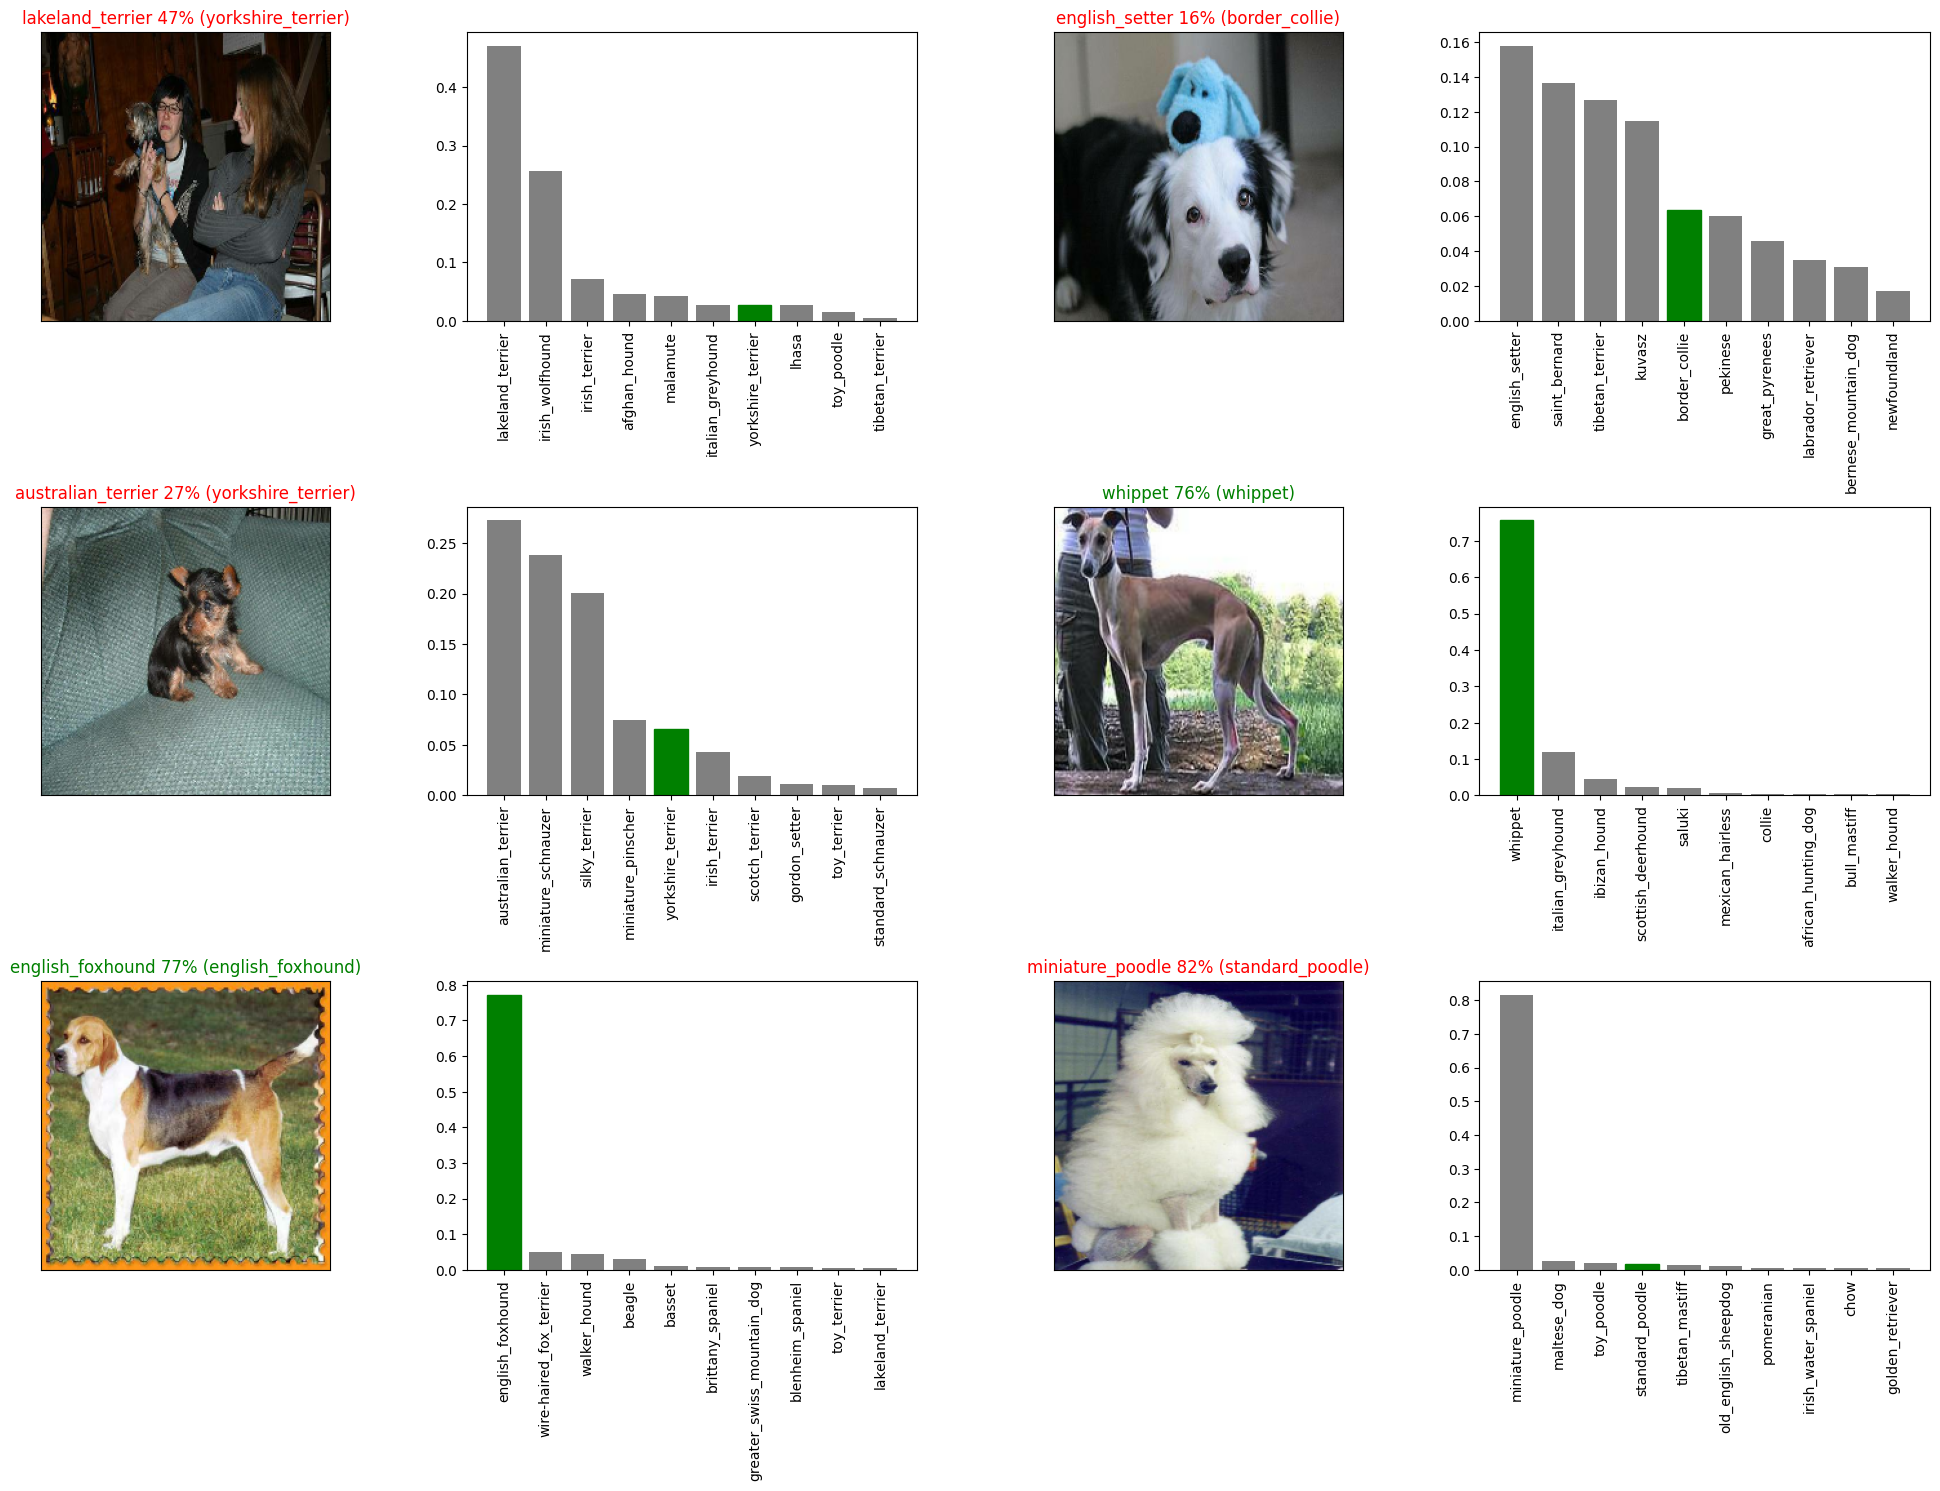

In [ ]:

# Let's check a few predictions and their different values
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading a trained model

Now we've got functions to save and load a traine a model, let's make sure they work!

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("drive/My Drive/Data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer},
                                     compile=True)
  return model

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-Adam")

Saving model to: drive/My Drive/Data/models/20241023-12151729685704-1000-images-Adam.h5...


'drive/My Drive/Data/models/20241023-12151729685704-1000-images-Adam.h5'

In [ ]:
# Load our model trained on 1000 images
model_1000_images = load_model('drive/My Drive/Data/models/20241023-12151729685704-1000-images-Adam.h5')

In [ ]:
# Check again if GPU is available (otherwise computing will take a looooonnnnggggg time)
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU not available :(


In [ ]:
model.evaluate(val_data)

7/7 [==============================] - 22s 3s/step - loss: 1.2953 - accuracy: 0.6200


[1.2953051328659058, 0.6200000047683716]

In [ ]:
# Evaluate the loaded model
model_1000_images.evaluate(val_data)

7/7 [==============================] - 14s 2s/step - loss: 1.2953 - accuracy: 0.6200


[1.2953051328659058, 0.6200000047683716]

## Training a big dog model ( on the full data)

In [ ]:
len(X), len(y)

(10222, 10222)

In [ ]:
# Create a data batch with the full data set
full_data = create_data_batches(X,y)

Creating training data batches...


In [ ]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Createa a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No Validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:** Running the cell below will take a little while
(maybe up to 30 minutes for the first epoch) because the GPU we're using in the runtime has to load all the images into memory.

In [ ]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard,
                          full_model_early_stopping])

NameError: name 'full_model' is not defined

In [ ]:
save_model(full_model, suffix="full_image_set_mobilenetv2_Adam")

Saving model to: drive/My Drive/Data/models/20241023-16571729702632-full_image_set_mobilenetv2_Adam.h5...


'drive/My Drive/Data/models/20241023-16571729702632-full_image_set_mobilenetv2_Adam.h5'

In [ ]:
# load in the full model
loaded_full_model = load_model("drive/My Drive/Data/models/20241023-16571729702632-full_image_set_mobilenetv2_Adam.h5")

# Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created 'create_data_batches()' earlier which can take a list of filenames as input and cover them into Tensor batches.

To make predictions on the test data, we'll
* Get the test image filenames
* Covert the filenames into test data batches using
`create_data_batches` and setting the `test_data`
parameter to `True`(since the test data doesn't have labels).
* Make a predictions array by passing the test batches to the predict() method called on our model.

In [ ]:
# Load test_image filenames
test_path = "drive/My Drive/Dog Vision/test/"
test_filenames = [test_path+fname for fname in os.listdir(test_path)]
test_filenames[:10]

In [ ]:
len(test_filenames)

10357

In [ ]:
import os
import shutil

# Path to your train directory
test_dir = "drive/My Drive/Dog Vision/test/"

# Get all files in the directory
all_files = os.listdir(test_dir)

# Identify files to remove (hidden or non-jpg)
files_to_remove = [
    f for f in all_files
    if (f.startswith(".") or not f.endswith(".jpg"))
]

# Remove the identified files
for file_name in files_to_remove:
    file_path = os.path.join(test_dir, file_name)
    if os.path.isfile(file_path):
        os.remove(file_path)
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)  # Use shutil.rmtree for directories

print(f"Removed {len(files_to_remove)} extra files from {test_dir}")


Removed 1 extra files from drive/My Drive/Dog Vision/test/


In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

In [ ]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

**Note** Calling `predict()` on our full model and passing it the test dat batch will take a long time to run (about an -1hr)

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data, verbose=1)

In [ ]:
# Save predictions (Numpy array) to csv files (for access later)
import numpy as np
np.savetxt("drive/My Drive/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

In [ ]:
# Load predictions (Numpy array) from csv file
test_predictions = np.loadtxt ("drive/My Drive/Dog Vision/preds_array.csv", delimiter=",")

Preparing test dataset predictions for Kaggle
Looking at the Kaggle sample submission, it looks like they want the models output probabilities each for label along with the image ID's.

To get the data in this format, we'll:

Create a pandas DataFrame with an ID column as well as a column for each dog breed.
Add data to the ID column by extracting the test image ID's from their filepaths.
Add data (the prediction probabilities) to each of the dog breed columns using the unique_breeds list and the test_predictions list.
Export the DataFrame as a CSV to submit it to Kaggle.

In [ ]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "drive/My Drive/Data/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

In [ ]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"]+list(unique_breeds))

In [ ]:
# Append test image ID's to predictions DataFrame
test_path = "drive/My Drive/Data/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

In [ ]:

# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

In [ ]:

preds_df.to_csv("drive/My Drive/Data/full_submission_1_mobilienetV2_adam.csv",
                 index=False)

Making predictions on custom images
It's great being able to make predictions on a test dataset already provided for us.

But how could we use our model on our own images?

The premise remains, if we want to make predictions on our own custom images, we have to pass them to the model in the same format the model was trained on.

To do so, we'll:

Get the filepaths of our own images.
Turn the filepaths into data batches using create_data_batches(). And since our custom images won't have labels, we set the test_data parameter to True.
Pass the custom image data batch to our model's predict() method.
Convert the prediction output probabilities to prediction labels.
Compare the predicted labels to the custom images.
Note: To make predictions on custom images, I've uploaded pictures of my own to a directory located at drive/My Drive/Data/dogs/ (as seen in the cell below). In order to make predictions on your own images, you will have to do something similar.

# Get custom image filepaths

In [ ]:
# Get custom image filepaths
custom_path = "drive/My Drive/Data/dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

In [ ]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels


In [ ]:

# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)